In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import time
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelBinarizer

In [2]:
model = tf.keras.models.load_model('models/convlstm_model_Datetime_2022_05_26__23_52_24__loss_0.08553284406661987_acc_0.9906666874885559.h5')

FEATURES_PATH = "data/my_20_sec_features-2022_05_26__19_44_46.npy"
LABELS_PATH = "data/my_20_sec_labels-2022_05_26__19_44_46.npy"
SCALER_MAX = 709.0

SEED = 42

2022-07-04 10:09:06.022501: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)

with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)

In [4]:
labels_order = [
    "www.amazon.co.uk",
    "www.bbc.co.uk",
    "www.ebay.co.uk",
    "www.facebook.com",
    "www.google.co.uk",
    "www.google.com",
    "www.twitter.com",
    "www.uwe.ac.uk",
    "www.wikipedia.com",
    "www.youtube.com"
]

In [5]:
label_binariser = LabelBinarizer()
label_binariser.fit(labels_order)
labels_encoded = label_binariser.transform(labels)
# labels_encoded = label_binariser.fit_transform(labels)
labels_encoded.shape

(3000, 10)

In [6]:
features.shape

(3000, 200, 150, 2)

In [7]:
features_scaled = features/SCALER_MAX

In [8]:
features_scaled.max()

1.073342736248237

In [9]:
model_evaluation_history = model.evaluate(features_scaled, labels_encoded)


94/94 [==============================] - 33s 340ms/step - loss: 0.0557 - accuracy: 0.9890


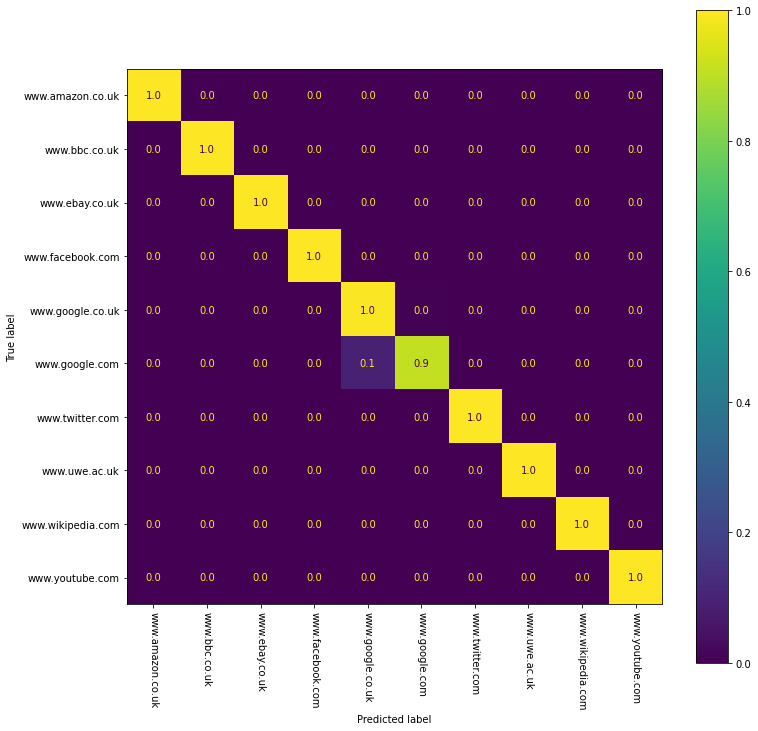

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       269
           2       1.00      1.00      1.00       297
           3       1.00      1.00      1.00       286
           4       0.91      0.99      0.95       301
           5       0.99      0.91      0.95       310
           6       1.00      1.00      1.00       290
           7       1.00      1.00      1.00       320
           8       1.00      1.00      1.00       308
           9       1.00      1.00      1.00       312

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
y_true = np.argmax(labels_encoded, axis=1)
unique_y = np.unique(y_true)
predictions =  np.argmax(model.predict(features_scaled), axis=1)
cm = confusion_matrix(y_true, predictions, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
    )
disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
plt.show()
print(classification_report(y_true, predictions))